# INFO 2950 Group Project: NBA Most Valuable Player (MVP) Candidacy
__Group Members__: Adya Bhargava (ab2446), Akhil Damani (ad674), Madeline Demers (mkd79)


## **Table of Contents**
1. Introduction <br>
    a. Background and Context <br>
    b. Research Question <br>
    c. Summary of Results <br>
    d. Data Collection and Cleaning Summary <br>
2. Data Description
3. Preregistration Statement
4. Data Analysis <br>
    a. Data Exploration <br> 
    b. Hypothesis 1 Analysis <br>
    c. Hypothesis 2 Analysis <br>
    d. Prediction Model
5. Evaluation of Significance
6. Interpretation and Conclusions
7. Limitations
8. Future Recommendations
9. *Appendix*

## **1. Introduction**



### A. Background and Context

The Most Valuable Player (MVP) award in the NBA stands as a high award of individual achievement, historically representing far more than statistical excellence. It's a testament to a player's performance and impact throughout a season, influencing multiple facets of the basketball landscape. In simple terms, it is awarded to the player that provides the most value to their team. However, the definition of value can be relatively subjective, making this an statistically interesting concept to further explore. Since there are so many factors that migth contribute to a player becoming selected as an MVP candidate, we considered looking into which factors were most influential to them being selected out of roughly 500 players per season. The drive for individual excellence often translates into collective success, as MVP-caliber players tend to elevate their team's performance. The MVP race captivates the baksetball community and it's a season-long narrative that sparks debates, discussions, and has seen various rule changes over the years. Before the 1979-80 season, NBA players determined the recipient of this award. However, since then, the responsibility shifted to sportswriters and broadcasters, forming a global panel of 100 members along with one fan vote to designate the recipient.
Each panel member casts five votes, ranking players from first to fifth place, each position carrying varying points. The player amassing the highest points from these voters claims the coveted title of NBA MVP. The specific criteria guiding the MVP selection process have never been officially disclosed, shrouding the decision-making process in mystery. It might seem straight forward that for example a player that scores more points is more valuable, but this is not necessarily the definition of "valuable" in terms of the award's meaning. In this project, we aim to assess which factors are statistically significant and predict the likeihood of a player being named as an MVP candidate, putting them up to the voting process to see if they will bring home the coveted award. The report includes basketball specific acronyms and terms (especially in the data), which are further described in the data description. The data was sourced from Basketball Reference, a sports statistics site, as well as from the NBA site itself.


### B. Research Question
**(Revised)** Is there a relationship between particular player or team statistics and a player being named as a candidate for the Most Valuable Player (MVP) award in the National Basketball Association (NBA) League? 

- **Sub Questions**
  - Can we build a prediction model for stat lines that are more likely to be nominated as a candidate/win the MVP award?  
- **Original Research Question**
  - Is there a relationship between particular player or team statistics and the Most Valuable Player (MVP) award in the National Basketball Association (NBA) League? 
    - In the process of working on the project we realized that the data we had, although spanning 20 seasons was not sufficent in volume to predict an MVP since there is only one per season, leaving us with only 20 data points. We decided to shift to the NBA candidates, which is typically about 10 per year, providing us with more data.


### C. Summary of Findings
We hypothesized that players would be more likely to be a candiate for the MVP award based on two factors: firstly, the average number of points scored by them per game, and second, the quality (in terms of winnings) of the team they belong to. Based on running logistic regressions on the influence of both of these factors, we found that both of them had statistically significant impact on the likelihood of an individual being a candidate for the MVP award: our hypothesis were proved correct. Based on this analysis, it would seem as if the higher points an individual scored had a positive impact on the likelihood of them being nominated for the MVP award. It would also seem as if the quality (or wins) of a team had a positive impact on the likelihood of the players of that team being nominated for the MVP.

### D. Data Collection and Cleaning Summary
The process of data collection and cleaning was an involved process from which we gathered data from the past 20 years (20 seasons) of NBA player and team statistics as well as historical award information related to the MVP award winners and candidates. It describes and contains the code for how we collected our data by scraping the NBA site and Basketball Reference. In order to do this we had to find data that was legal to scrape and unlocked, which proved to be a difficult process. For example, the NBA site lets users access the player data, but not the team data. Furthermore, similar site also proved to be challenging in terms of accessing the data so to get the historical list of MVPs for the past 20 years, we ended up having to scrape a text article in order to get this data.  We ended up with serveral '.csv' files which we use as our main data sources in the report. See the appendix for the file that contains the code and descriptions for collection and cleaning of the data useed in this main report.


In [2]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import duckdb
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, classification_report

In [3]:
mvp_df = pd.read_csv('Appendix/mvp_df.csv')
mvp_candidates_df = pd.read_csv('Appendix/mvp_candidates.csv')
player_stats_df = pd.read_csv('Appendix/player_stats.csv')
all_team_stats_df = pd.read_csv('Appendix/all_team_stats.csv')
player_stats_df = player_stats_df.drop("Unnamed: 0", axis=1)
all_team_stats_df = all_team_stats_df.drop("Unnamed: 0", axis=1)
mvp_candidates_df = mvp_candidates_df.drop("Unnamed: 0", axis=1)
mvp_df = mvp_df.drop("Unnamed: 0", axis=1)


## **2. Data Description**

**What are the observations (rows) and the attributes (columns)?**

In the player_stats_df the observations (rows) are the statistics of all of the players in the NBA from the 2003-2004 season to the 2022-23 season that are considered to be qualified to rate league leaders (please see the data limitations section for more explanation on this concept). The attributes (columns) are as follows:
  - PLAYER: Player Name
  - TEAM: Team Name as an abbreviation
  - FULL_NAME: The full name of the team
  - SEASON: The season of play for that row's statistics
  - GP: Games played
  - MIN: Minutes played
  - FGM: Field Goals Made
  - FGA: Field Goals Attempted
  - FG_PCT: Field Goal Percentage
  - FG3M: 3 Point Field Goals Made
  - FG3A: 3 Point Field Goals Attempted
  - FG3_PCT: 3 Point Field Goal Percentage
  - FTM: Free Throws Made
  - FTA: Free Throws Attempted
  - FT_PCT: Free Throws Percentage
  - OREB: Offensive Rebounds
  - DREB: Defensive Rebounds
  - REB: Rebounds
  - AST: Assists
  - STL: Steals
  - BLK: Blocks
  - TOV: Turnovers
  - PTS: Points
  - EFF: Player Efficiency Rating
    - (Calculated as (PTS + REB + AST + STL + BLK − Missed FG − Missed FT - TO) / GP)
  - is_mvp: A binary variable indicating if the player is an MVP for that particular season (1) or not (0)
  - is_candidate: A binary variable indicating if the player is an MVP candidate for that particular season (1) or not (0)
  - W: Number of wins the player's team has for that season
  - L: Number of losses the player's team has for that season

In the team_stats_df, the observations (rows) are the team statistics for all of the seasons between 2003-2004 to 2022-2023 and the attributes (columns) are as follows:
  - 'Rk': Rank (per season)
  - 'Team': Team Name
  - 'G': Games Played
  - 'MP': Minutes Played
  - 'FG': Field Goals
  - 'FGA': Field Goals Attempted
  - 'FG%': Field Goal Percentage
  - '3P': 3 Point Field Goals
  - '3PA': 3 Point Field Goal Attempts
  - '3P%': 3 Point Field Goal Percentage
  - '2P': 2 Point Field Goals
  - '2PA': 2 Point Field Goal Attempts
  - '2P%': 2 Point Field Goal Percentage
  - 'FT': Free Throws
  - 'FTA': Free Throw Attempts
  - 'FT%': Free Throw Percentage
  - 'ORB': Offensive Rebounds
  - 'DRB': Defensive Rebounds
  - 'TRB': Total Rebounds
  - 'AST': Assists
  - 'STL': Steals
  - 'BLK': Blocks
  - 'TOV': Turnovers
  - 'PF': Personal Fouls
  - 'PTS': Points
  - 'Age': Average Age in Team
  - 'W': Wins
  - 'L': Losses
  - 'Season': Season
- The MVP data set has observations (rows) for each season's MVP. The columns or attributes are originally the season years and the name of the MVP (these were merged in the cleaning process to get more data).

**Why was this dataset created?**
  
  The 'player_stats_df' was created in order to track and save the historical statistics of NBA players during their regular season.
  The 'team_stats_df' was created to track the historical statistics of the teams for each NBA season for the past 20 years
  The 'mvp_df' was created to track the historical list of MVPs for the past 20 seasons of the NBA
  The 'mvp_candidates_df' was created to track the historical list of MVP candidates for the past 20 seasons of the NBA

**Who funded the creation of the dataset?**
  
  The NBA funded the player_stats_df data set and the insights were run with SAP. The NBA funded the article that was scraped to get the list of historical MVPs. The team_stats and mvp_candidates_df were funded by Sports Reference LLC and Stathead.

**What processes might have influenced what data was observed and recorded and what was not?**
  
  The processes that influenced what data was observed and recorded and what was not was likely realted to the typical gameplay of an NBA game and what statistics are significant, such as points, rebounds, and other values. Other aspects of a player's performance may receive less attention.

**What preprocessing was done, and how did the data come to be in the form that you are using?**
  
  The preprocessing done can be seen in the data_collection file, which was mostly consistent of web scraping by us. We collected the data straight from the source and then cleaned it in this file. The data came in to be in the form that we are using by finding reliable sources and then collecting that data and cleaning it for proper and effective use. 

**If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?**
  
  The people involved are all NBA players, who are listed in the data set and since they signed a contract to play in the NBA it is expected that they are aware this data was being collected and used for purposes such as analytics and insights, as we are doing here.
  
**Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted on Github, in a Cornell Google Drive or Cornell Box).**
  
  - https://www.basketball-reference.com/leagues/NBA_2004.html (and all other years, for seasons 2003-2004 to 2022-2023)
  - https://www.nba.com/stats/leaders (for all seasons from 2003-04 to 2022-23)
  - https://www.nba.com/news/history-mvp-award-winners


## **3. Preregistration Statement**

**Hypothesis 1:** The player with the most points per game on average during the season is more likely to be a candidate for the award than other players.

- $H_0$: The player with the most points per game on average during the season has an equal or lesser likelihood of being a candidate for the award compared to other players.
- $H_A$: The player with the most points per game on average during the season is more likely to be a candidate for the award than other players.

**Hypothesis 2:** The team with the most wins is more likely to have one of its players be a candidate for MVP.
- $H_O$: The team with the most wins has an equal or lesser likelihood of having one of its players be a candidate for MVP compared to other teams.
- $H_A$: The team with the most wins is more likely to have one of its players be a candidate for MVP than other teams.

## 4. Data Analysis

### A. Exploratory Data Analysis (EDA)


Reviewing the correlation between variables

In [4]:

features = ['is_candidate','is_mvp','GP', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', 'EFF', 'W', 'L']
player_stats_df[features].corr()

,is_candidate,is_mvp,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,DREB,REB,AST,STL,BLK,TOV,PTS,EFF,W,L
is_candidate,1.000000,0.274710,0.045265,0.323211,0.481428,0.444319,0.103499,0.133718,0.140151,0.040034,...,0.319305,0.260728,0.370727,0.301986,0.149096,0.429914,0.504438,0.521072,0.126070,-0.122245
is_mvp,0.274710,1.000000,0.027696,0.089562,0.168981,0.144089,0.053673,0.068405,0.066046,0.032672,...,0.125748,0.098492,0.162596,0.102587,0.039812,0.166043,0.178107,0.205405,0.062213,-0.062062
GP,0.045265,0.027696,1.000000,0.218192,0.082935,0.081149,0.011809,-0.069430,-0.082386,-0.070620,...,0.076814,0.091113,0.042666,0.095826,0.056520,0.102284,0.070819,0.081687,0.131215,0.077009
MIN,0.323211,0.089562,0.218192,1.000000,0.833492,0.843891,0.025510,0.399742,0.411094,0.162627,...,0.542359,0.463567,0.581035,0.634239,0.183477,0.732584,0.832463,0.806853,0.010650,-0.001028
FGM,0.481428,0.168981,0.082935,0.833492,1.000000,0.971936,0.161762,0.388021,0.402872,0.145931,...,0.560406,0.482172,0.550472,0.510512,0.195773,0.787236,0.983246,0.897181,0.066099,-0.070067
FGA,0.444319,0.144089,0.081149,0.843891,0.971936,1.000000,-0.049567,0.504745,0.530999,0.229898,...,0.455501,0.356322,0.595522,0.548324,0.079434,0.794824,0.976040,0.819409,0.034353,-0.037784
FG_PCT,0.103499,0.053673,0.011809,0.025510,0.161762,-0.049567,1.000000,-0.419965,-0.461846,-0.397038,...,0.437524,0.533433,-0.145967,-0.115130,0.502076,0.029085,0.083476,0.355404,0.119298,-0.122626
FG3M,0.133718,0.068405,-0.069430,0.399742,0.388021,0.504745,-0.419965,1.000000,0.988152,0.585029,...,-0.085919,-0.233538,0.368210,0.303144,-0.324759,0.263058,0.478367,0.234365,0.089058,-0.115750
FG3A,0.140151,0.066046,-0.082386,0.411094,0.402872,0.530999,-0.461846,0.988152,1.000000,0.573045,...,-0.081268,-0.232949,0.396624,0.333471,-0.328481,0.295921,0.494039,0.240340,0.073575,-0.101378
FG3_PCT,0.040034,0.032672,-0.070620,0.162627,0.145931,0.229898,-0.397038,0.585029,0.573045,1.000000,...,-0.216826,-0.337989,0.251568,0.186584,-0.374329,0.082351,0.201601,0.014323,0.047880,-0.062409


Here are some interesting things to note. The EFF or the efficiency rating has a strong positive correlation with perfoamcne related statistics like points, assists, rebounds, and blocks. Obviously variables like field goals made (FGM) has a high correlation with points. This similar idea is present in a few different variables like with minutes and scoring metrics.

In this plot, we compare the average points of players across the 2010-11 season with the average number of points for the MVP to visualize this comparison. 

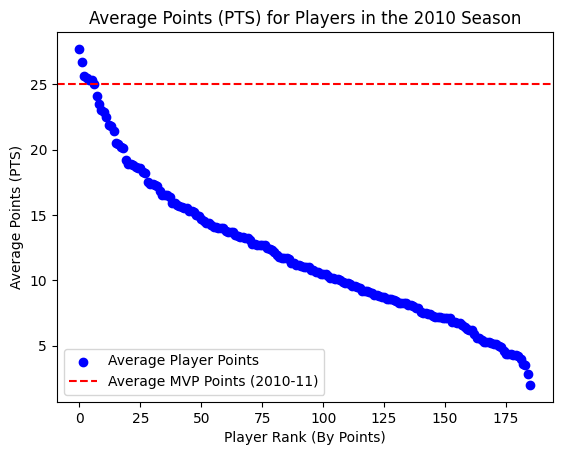

In [5]:
player_stats_2010 = player_stats_df[player_stats_df['SEASON'] == '2010-11']
mvp_stats_2010 = player_stats_df[(player_stats_df['SEASON'] == '2010-11') & (player_stats_df['is_mvp'] == 1)]

player_pts_2010 = player_stats_2010['PTS']

mvp_pts_2010 = mvp_stats_2010['PTS'].values[0]

plt.scatter(range(len(player_pts_2010)), player_pts_2010, label=\
            'Average Player Points', color='blue')
plt.axhline(y=mvp_pts_2010, color='red', linestyle='--',\
             label='Average MVP Points (2010-11)')
plt.title('Average Points (PTS) for Players in the 2010 Season')
plt.xlabel('Player Rank (By Points)')
plt.ylabel('Average Points (PTS)')
plt.legend()
plt.show()

For this graph we can see that even less than the top 25 players in the NBA for points are near the average points for the MVP which really narrows the scope of players that can really be considered MVP candidates. 

Visualizing the relationship between the average points of the MVP player and the average of all players for each year

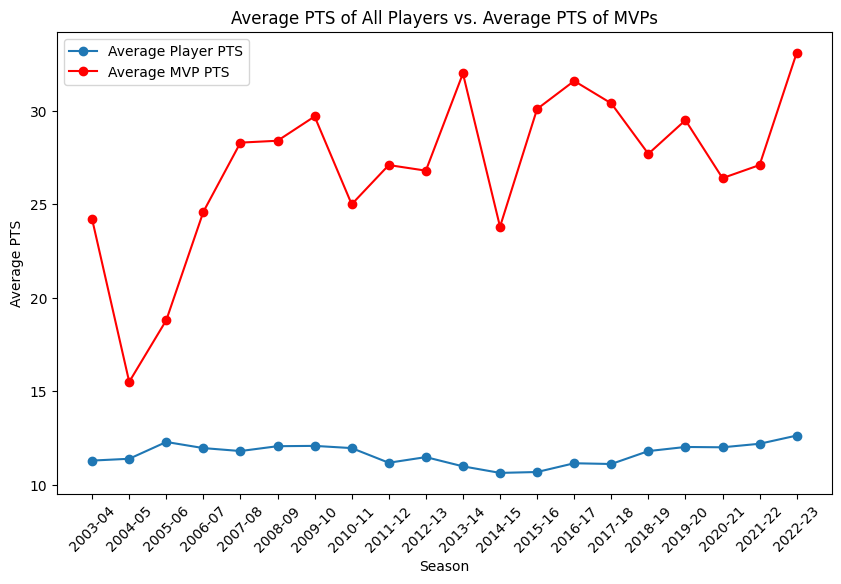

In [6]:
avg_player_pts_by_season = player_stats_df.groupby('SEASON')['PTS'].mean()

avg_mvp_pts_by_season = player_stats_df[player_stats_df['is_mvp'] == 1].groupby('SEASON')['PTS'].mean()

plt.figure(figsize=(10, 6))
plt.plot(avg_player_pts_by_season.index, avg_player_pts_by_season.values, marker='o', label='Average Player PTS')
plt.plot(avg_mvp_pts_by_season.index, avg_mvp_pts_by_season.values, marker='o', label='Average MVP PTS', color='red')

plt.title('Average PTS of All Players vs. Average PTS of MVPs')
plt.xlabel('Season')
plt.ylabel('Average PTS')
plt.xticks(rotation=45) 
plt.legend()
plt.show()

In this graph that no matter what the mvp points has always been above the average points scored by an NBA player. We can note that there has been relatively no major shifts in the average NBA player points but there has been some fluctuation in the MVP points as seen in 2004-05 with a huge dip but for the most part the average mvp points are around 25 to 30.

This shows the average points by players over the years

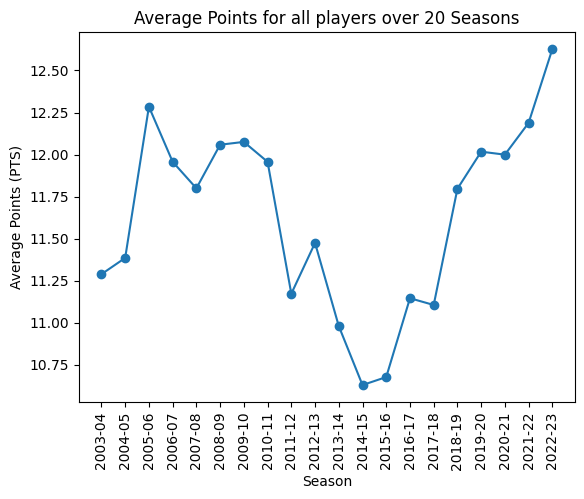

In [7]:
average_pts = player_stats_df.groupby('SEASON')['PTS'].mean()

plt.plot(average_pts, marker='o')
plt.title('Average Points for all players over 20 Seasons')
plt.xlabel('Season')
plt.ylabel('Average Points (PTS)')
plt.xticks(rotation=90)
plt.show()


This shows the average of all assists over 20 seasons 

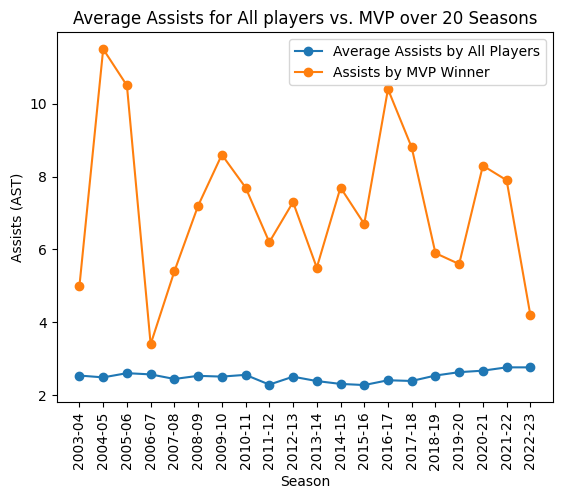

In [8]:
average_ast = player_stats_df.groupby('SEASON')['AST'].mean()
mvp_ast_by_season = player_stats_df[player_stats_df['is_mvp'] == 1].groupby('SEASON')['AST'].mean()

plt.plot(average_ast, marker='o', label = 'Average Assists by All Players')
plt.plot(mvp_ast_by_season, marker='o', label = 'Assists by MVP Winner')

plt.title('Average Assists for All players vs. MVP over 20 Seasons')
plt.xlabel('Season')
plt.ylabel('Assists (AST)')
plt.xticks(rotation=90)
plt.legend()
plt.show()


In the data it looks like the average assists by all players are relatively constants while the assists by the MVP winner fluctuates heavily. It is interesting to note when you look at the 2004-05 and 2005-06 seasons you can see huge increases in mvp assists numbers apart for 2016-17. In these two seasons the MVP was Steve Nash who was known for his passing ability and you can see that while he had a high number of assists his points were the two lowest for an MVP in the last 20 seasons. This is just something interesting to note when we look at how these performance variables relate to players being selected for MVP.

This aims to show the average age of MVP candidates in the NBA over 20 years

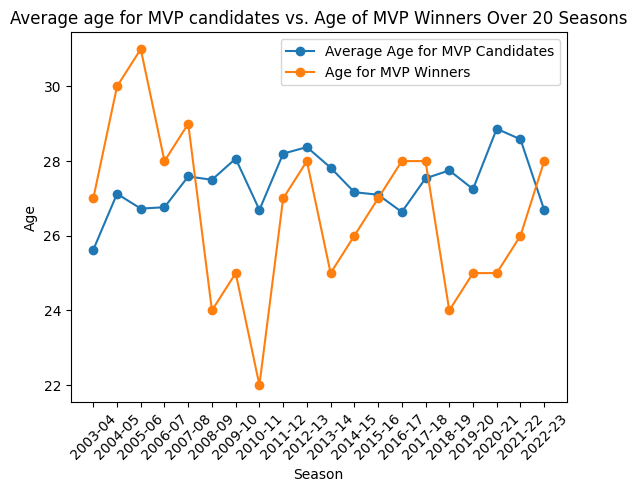

In [9]:
average_age = mvp_candidates_df.groupby('SEASON')['Age'].mean()
age = mvp_candidates_df[mvp_candidates_df['is_mvp'] == 1].groupby('SEASON')['Age'].mean()

plt.plot(average_age, marker='o', label='Average Age for MVP Candidates')
plt.plot(age, marker='o', label='Age for MVP Winners')
plt.title('Average age for MVP candidates vs. Age of MVP Winners Over 20 Seasons')
plt.xlabel('Season')
plt.ylabel('Age')
plt.xticks(rotation=45)  
plt.legend()
plt.show()


Overall the graph looks like it is fluctuating a lot not showing a lot of general trends for the age of the MVP

This plots aims to show the average amount of wins for a team that has an mvp player vs the average nba team 

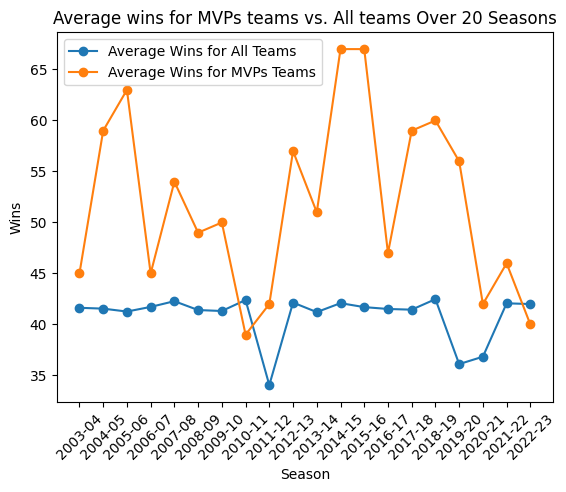

In [84]:
nba_avg_wins = player_stats_df.groupby('SEASON')['W'].mean()
mvp_avg_wins = player_stats_df[player_stats_df['is_mvp'] == 1].groupby('SEASON')['W'].mean()

plt.plot(nba_avg_wins, marker='o', label='Average Wins for All Teams ')
plt.plot(mvp_avg_wins, marker='o', label='Average Wins for MVPs Teams')
plt.title('Average wins for MVPs teams vs. All teams Over 20 Seasons')
plt.xlabel('Season')
plt.ylabel('Wins')
plt.xticks(rotation=45)  
plt.legend()
plt.show()

From this graph we can see that usually the MVP team tends to almost always do better than the average team. In the context of the graph we can see a few distinct dips, one in 2011-12 and from 2019 to 2021. The reason for the first is due to an NBA shutdown and then the second dip was due to a shortening of the seasons because of the pandemic. There also appear to be two outliers for which they were worse than the average NBA team in 2010 and 2022.

Checking how many times there have been repeat MVP winners

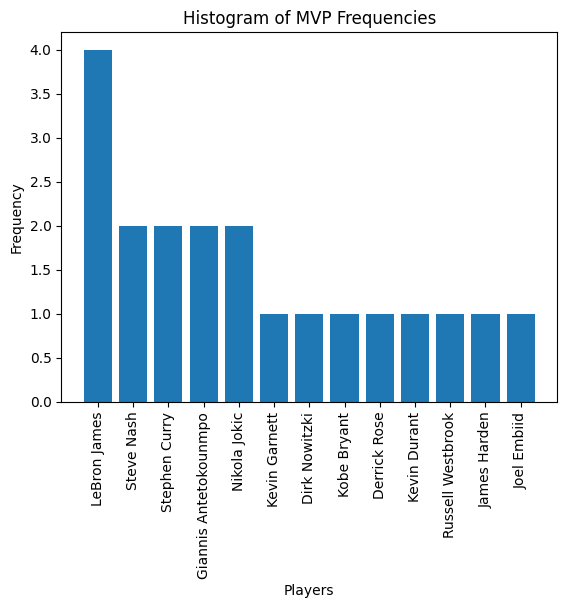

In [11]:
mvp_stats = player_stats_df[player_stats_df['is_mvp'] == 1]
name_counts = mvp_stats['PLAYER'].value_counts()
plt.bar(name_counts.index, name_counts.values)
plt.xlabel('Players')
plt.ylabel('Frequency')
plt.title('Histogram of MVP Frequencies')
plt.xticks(rotation=90)
plt.show()


This does provide some interesting information that many of the MVP's have been repeat winners over the last 20 seasons with 4 winning twice and 1 player winning 4 times. It can be somewhat implied that players typically perform very well consistenly over the years are MVP players, however, this is just a guess. Also, it is interesting to note that while it doesn't show up on the graph many of these players won MVP trophies in consecutive years such as LeBron, Steve Nash, and Stephen Curry.

### B. Hypothesis 1 Analysis

Hypothesis 1: The player with the most points per game on average during the season is more likely to win the award than other players.


For this analysis, we decided to run a logistic regression. We used the statsmodel Logit function and the lecture slides to help us. We got a summary of the results to better understand how this compares to our hypothesis.


In [12]:
#Making sure that repeated names across different seasons do not impact the regression
regression_df = player_stats_df.copy()
regression_df['Last_2_Digits_Season'] = player_stats_df['SEASON'].str[-2:]
regression_df['Player_With_Last_2_Digits'] = regression_df['PLAYER'] + '_' + regression_df['Last_2_Digits_Season']


X = player_stats_df[['PTS']]
X = sm.add_constant(X)
y = player_stats_df['is_candidate'].astype(int)


#Source: Lecture notes
model = sm.Logit(y, X)
result = model.fit()
print(result.summary())



Optimization terminated successfully.
         Current function value: 0.109520
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:           is_candidate   No. Observations:                 4386
Model:                          Logit   Df Residuals:                     4384
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Dec 2023   Pseudo R-squ.:                  0.5005
Time:                        22:25:51   Log-Likelihood:                -480.36
converged:                       True   LL-Null:                       -961.72
Covariance Type:            nonrobust   LLR p-value:                2.277e-211
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.4594      0.395    -23.975      0.000     -10.233      -8.686
PTS            0.3858      0.

### C. Hypothesis 2 Analysis


Hypothesis 2: The team with the most wins is more likely to have one of its players win 

For this analysis, we used the statsmodel Logit function and the lecture slides to run a logistic regression. We got a summary of the results to better understand how this compares to our hypothesis.


In [13]:
X = player_stats_df[['W']]
X = sm.add_constant(X)
y = player_stats_df['is_mvp'].astype(int)
model = sm.Logit(y, X)
result = model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.027025
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                 is_mvp   No. Observations:                 4386
Model:                          Logit   Df Residuals:                     4384
Method:                           MLE   Df Model:                            1
Date:                Sun, 03 Dec 2023   Pseudo R-squ.:                 0.07227
Time:                        22:25:51   Log-Likelihood:                -118.53
converged:                       True   LL-Null:                       -127.76
Covariance Type:            nonrobust   LLR p-value:                 1.730e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.5333      1.169     -8.152      0.000     -11.825      -7.241
W              0.0889      0

### D. Prediction Model

So we decided to use a logistic regression to classify players as mvp candidate or not based on their basic perfomance stats. We decided to use points, assists, rebounds, blocks, and steals as the main metrics for the model due to statistical consideratiosn and our knowledge of basketball. The reasoning behind using those specific variables is that there is little overlap/collinearity between these variables and they all touch on a different aspect of the players game which is recognized when voting for an MVP. Also, most of these variables had a relatively strong positive correlation with being an MVP candidate. We decided to excluse EFF due to the fact that it had a very high correlation with these main performance stats which can suggest collinearity.

In [83]:
X = player_stats_df[['PTS', 'AST', 'REB', 'BLK', 'STL']]
y = player_stats_df['is_candidate'].astype(int)

train_seasons = ["2003-04", "2004-05", "2005-06", "2006-07", "2007-08", \
                 "2008-09", "2009-10", "2010-11", \
    "2011-12", "2012-13", "2013-14", "2014-15", "2015-16", "2016-17", \
        "2017-18", "2018-19", "2019-20", "2020-21", \
    "2021-22"]
test_season = ["2022-23"]

X_train = X[player_stats_df['SEASON'].isin(train_seasons)]
y_train = y[player_stats_df['SEASON'].isin(train_seasons)]

X_test = X[player_stats_df['SEASON'].isin(test_season)]
y_test = y[player_stats_df['SEASON'].isin(test_season)]

log_reg = LogisticRegression()

model = log_reg.fit(X_train, y_train)

predictions = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
report= classification_report(y_test, predictions)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.9673469387755103
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       233
           1       0.64      0.75      0.69        12

    accuracy                           0.97       245
   macro avg       0.81      0.86      0.84       245
weighted avg       0.97      0.97      0.97       245



So this provides us with some very interesting data. Firstly we can see that we have an accuracy score of approximately 0.97 which means that our model was correct 97% of the time however, this statistic can be somewhat misleading therefore it is important to look at the classification report. The classification report breaks down the model's perfomance for each class individually, whether they are mvp candidates or not. You can see that there is a disaprity between the precision, recall and f1 score for predicting non MVP candidates versus MVP candidates. This is most likely due to the fact that the model can easily predict who is not an mvp candidate but has harder time distinguishing those who are candidates which is the reason that the accuracy for our model is so high since there is a larger sample size for non mvp candidates and those are being correctly predicted. We can also see that the macro avg has a huge difference between the weighted avg showing its affects on the accuracy.

At first due to the very high accuracy score there was a concern over overfitting which would dampen any use for generalizations into the future but after taking into account some of these other factors the model doesn't seem to be overfitting. In the future we would definetly like to test it on more data to see how accurately the model predicts over a few seasons. I believe that the reason for the subpar precision and recall scores in class 1 (mvp candidates) is most likely due to a lack of data for mvp candidates.   

In [85]:
def predict_mvp_candidate(player_name, season, model):

    player_in_season = (player_stats_df['PLAYER'] == player_name) & \
        (player_stats_df['SEASON'] == season)

    if not player_in_season.any():
        return f"No data found for {player_name} in {season}. They did not play \
            in the {season} season or they did not qualify as a league leader \
            for the {season} season."

    season_data = player_stats_df[player_stats_df['SEASON'] == season]
    player_features = season_data[season_data['PLAYER'] == player_name][\
        ['PTS', 'AST', 'REB', 'BLK', 'STL']].values
    
    prediction = model.predict(player_features)
    
    if prediction[0] == 1:
        return f"{player_name} is predicted to be an MVP candidate!"
    else:
        return f"{player_name} is not predicted to be an MVP candidate."

So below we have just sense checked out predictive model with a player that has exceptional stats and was an mvp candidate (good) and should do well in the predictive model and then another player who is less likely to be an mvp candidate and not an mvp candidate (bad)

In [86]:
#Good player and is an MVP candidate
player_name= "Shai Gilgeous-Alexander"
target_season = "2022-23"

prediction_result = predict_mvp_candidate(player_name, target_season, log_reg)
print(prediction_result)

Shai Gilgeous-Alexander is predicted to be an MVP candidate!


C:\Users\akhd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [87]:
#Average player
player_name = "Jrue Holiday"
target_season = "2022-23"

prediction_result = predict_mvp_candidate(player_name, target_season, log_reg)
print(prediction_result)

Jrue Holiday is not predicted to be an MVP candidate.


C:\Users\akhd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


## 5. Evaluation of Significance


**For Hypothesis 1**: The significance level is 0, which is less than 0.05, thus we reject our null hypothesis. A player scoring more points per season indicates that they are not equally as likely as other players to be a candidate for the most valuable player award. Since the coefficient was greater than 0, then this means that scoring more points increases the chance that a player will be named an MVP candidate.

**For Hypothesis 2**: The significance level is 0, which is less than 0.05, thus we reject our null hypothesis. A player being on a team that wins more games per season indicates that they are not equally as likely as other players to be a candidate for the most valuable player award. Since the coefficient was greater than 0, then this means that being a part of a team that has been winning more games increases the chance that a player will be named an MVP candidate.

## 6. Interpretation & Conclusions




### Hypothesis 1:
- We reject the null hypothesis in this case, determining that a player scoring more points (‘PTS’) makes them not equally as likely to win MVP than other players. 
- For each unit increase in 'PTS', the log-odds of a player being an MVP candidate increases by approximately 0.3858 units. This would suggest that with each additional point scored, the odds of a player being an MVP candidate increase by about e^0.3858 times or roughly 1.47 times. So, a one-point increase in points scored is associated with a 47% higher likelihood of a player being considered an MVP candidate.
- The coefficient for 'PTS' is statistically significant (p < 0.05), indicating that the variable, ‘PTS’, has a significant impact on predicting whether a player is an MVP candidate or not. 
- According to this logistic regression model, there is a statistically significant relationship between the number of points scored (PTS) and the likelihood of a player being an MVP candidate. 
- As the number of points scored increases, the odds of being an MVP candidate also increase.

### Hypothesis 2: 
- We reject the null hypothesis in this case, determining that a player belonging to a team winning more games (‘W’) makes them not equally as likely to win MVP than other players.
- For each additional win (increase in 'W'), the log-odds of a player being an MVP increases by approximately 0.0889 units. This suggests that with each extra win, the odds of a player being an MVP increase by about e^0.0889 times or approximately 1.09 times. So, a one-game increase in games won is associated with a 9% higher likelihood of a player being considered an MVP candidate.
- The coefficient for ‘W’ is statistically significant (p < 0.05), indicating that the variable, ‘W’, has a significant impact on predicting whether a player is an MVP candidate or not. 
- According to this logistic regression model, there appears to be a statistically significant relationship between the number of wins a team has and the likelihood of a player being an MVP. Specifically, for each additional win, there is an increase in the odds of a player being an MVP.


## 7. Limitations

The dataset scraped and built for the project encompasses a comprehensive collection of statistics and historical records spanning the past 20 seasons of the NBA including specifics about players and teams as well as the historical records of who received the MVP award for the past 20 seasons. It is a set that will be a resource for us when we aim to build a predictive model to estimate the probability of a player receiving the MVP award in future seasons. This dataset comprises various types of information, including individual player statistics, team statistics, and records of MVP winners, offering a multi-faceted view of the league's performance dynamics.

While this dataset has a lot of quality data that has been carefully collected and cleaned, it is not without its limitations. We only collected data on players who qualified for being considered a “league leader”, players must meet specific criteria in certain categories of game by game statistics. The data that was collected is of the league leaders for each season. If a player did not reach the criteria, they were not factored into consideration for the MVP candidacy. The categories are basketball scoring, rebounds, assists, steals, blocked shots, minutes, field goal percentage, free throw percentage, three-point percentage, assist-to-turnover ratio, and steal-to-turnover ratio. They must play at least 70% of their team's games in an 82-game season for scoring, rebounds, assists, steals, blocked shots, and minutes. Additionally, they need to achieve minimums such as making 300 field goals, 125 free throws, 82 three-pointers, garnering 200 assists, and securing 82 steals. Statistical minimums exist in the NBA to establish a benchmark for players to qualify for certain statistical categories and league leaders. These minimums ensure that the players who lead in various statistical areas have a significant impact and consistent performance throughout the season. By setting these minimum thresholds (e.g., minimum games played or specific statistical benchmarks), the league ensures that the players considered for leading categories have actively contributed and maintained a certain level of performance, rather than being included based on limited or sporadic participation. This helps maintain the integrity of the statistical leaders and emphasizes consistent performance over the course of the season. 

Moreover, the data may be influenced by selection biases, as MVP awards can be influenced by non-statistical factors, such as media attention and player popularity. The dataset's relatively small sample size of MVPs compared to the total player population can present statistical challenges. Furthermore, it is essential to consider the evolving nature of the game, encompassing rule changes, shifts in playing style, and variations in MVP selection criteria, which the dataset might not fully encapsulate. There also is consideration not addressed for player injuries, retirements, team trades, and other insights that might be at play in the selection process. That being said, our data also covers the time during the pandemic when fewer games were played and the regular seasons were interrupted. Given the relatively small number of MVPs each season, there is a risk of overfitting the model to historical MVPs, making it less applicable for predicting future MVPs. Also, if player statistics are highly correlated, this can lead to multicollinearity issues when building predictive models. This can make it challenging to determine which individual statistics truly contribute to MVP selection. 

## 8. Future Recommendations

To enhance the predictive accuracy of identifying MVP candidates and winners in the NBA, future recommendations could involve leveraging advanced analytics and machine learning techniques. Moreover, incorporating qualitative aspects such as leadership qualities, impact on team chemistry, social media presence, and off-court contributions could add depth to the analysis. Combining quantitative data with qualitative assessments might lead to a more nuanced evaluation of MVP-caliber players. Embracing advancements in data analytics and machine learning while considering the multifaceted nature of a player's impact could pave the way for more robust predictions regarding MVP candidates and eventual winners in the NBA.

## 9. Appendix

Please see the following in our GitHub repository:
(https://github.com/INFO-2950-FA23/GroupProject)
- appendix.ipynb - for data collection and cleaning description
- See the appendix folder for all of the '.csv' files used in our project